In [1]:
# --- Célula 1: Imports e Configurações ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import shap
import xgboost
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

cols_dict = {
    'track_id': 'Track ID', 'artists': 'Artists', 'album_name': 'Album Name',
    'track_name': 'Track Name', 'popularity': 'Popularity', 'duration_ms': 'Duration (ms)',
    'explicit': 'Explicit', 'danceability': 'Danceability', 'energy': 'Energy',
    'key': 'Key', 'loudness': 'Loudness', 'mode': 'Mode', 'speechiness': 'Speechiness',
    'acousticness': 'Acousticness', 'instrumentalness': 'Instrumentalness',
    'liveness': 'Liveness', 'valence': 'Valence', 'tempo': 'Tempo',
    'time_signature': 'Time Signature', 'track_genre': 'Track Genre'
}

c:\Users\Gabriel Augusto\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Célula 2: Carregamento dos Dados ---
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")
df = pd.read_csv(path + '/dataset.csv', index_col=0)
# Remova colunas duplicadas
df = df.loc[:, ~df.columns.duplicated()]
if 'track_genre' not in df.columns:
    df['track_genre'] = 'unknown'

num_features = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]

# Remova qualquer coluna extra
df = df[num_features + ['track_genre']].copy()


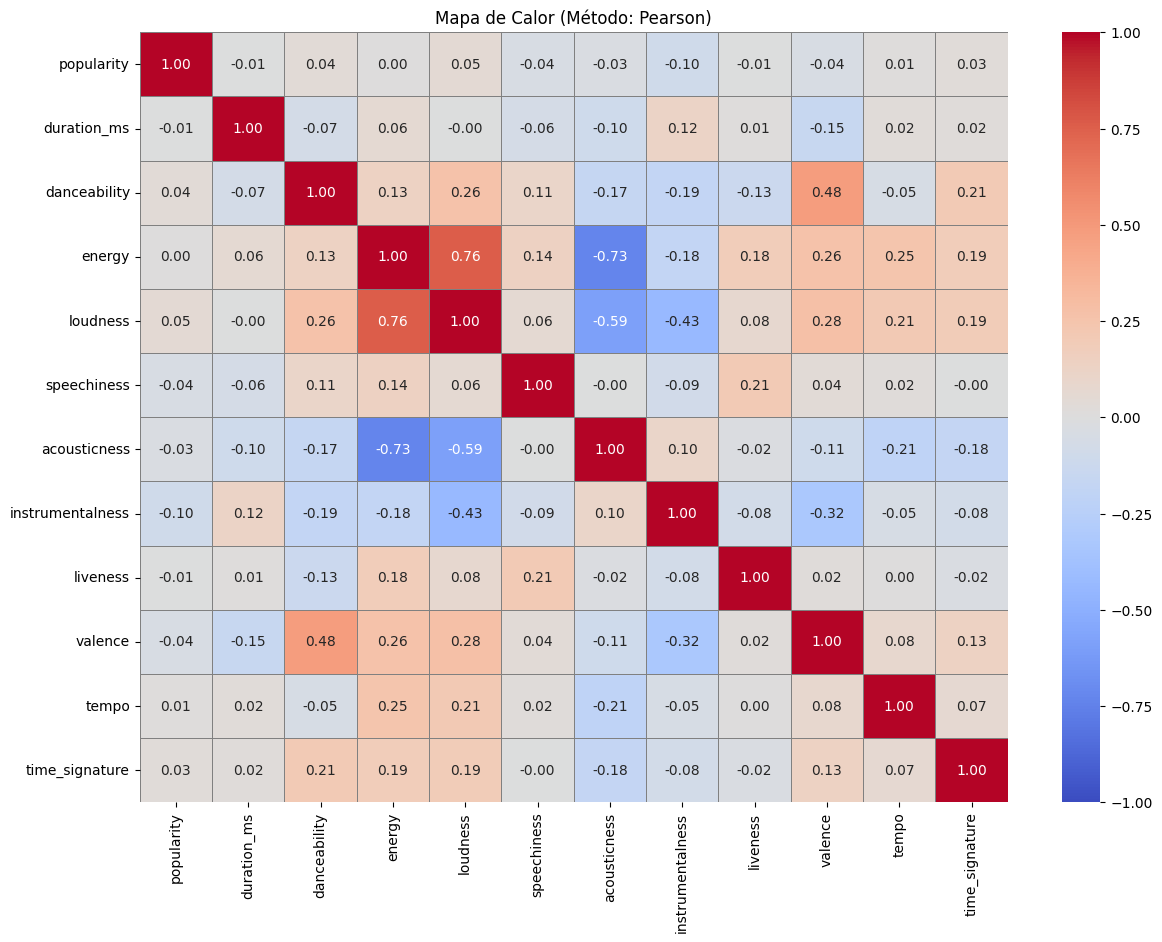

energy        loudness            0.761690
              acousticness       -0.733906
loudness      acousticness       -0.589803
danceability  valence             0.477341
loudness      instrumentalness   -0.433477
dtype: float64

In [3]:
# --- Célula 8: Correlação ---
corr_method = "pearson"
corr_matrix = df[num_features].corr(method=corr_method)
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
plt.title(f"Mapa de Calor (Método: {corr_method.capitalize()})")
plt.show()

# Pares com maior correlação
mask_table = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_unstacked = corr_matrix.where(mask_table).stack()
strong_pairs = corr_unstacked[abs(corr_unstacked) > 0.4].sort_values(key=abs, ascending=False)
display(strong_pairs)

Detectados 5700 outliers.


,track_genre,danceability,energy,loudness,acousticness,valence,instrumentalness
116,acoustic,0.5650,0.0392,-28.276,0.835,0.6010,0.183
163,acoustic,0.7390,0.2870,-14.007,0.969,0.5570,0.961
173,acoustic,0.7690,0.1350,-12.049,0.986,0.4710,0.905
284,acoustic,0.7340,0.0423,-24.831,0.916,0.1400,0.000
324,acoustic,0.3860,0.4280,-9.949,0.951,0.7300,0.882
...,...,...,...,...,...,...,...
113972,world-music,0.1700,0.0520,-28.693,0.875,0.0475,0.904
113977,world-music,0.0672,0.0903,-23.496,0.970,0.0361,0.977
113979,world-music,0.4170,0.9670,-27.146,0.924,0.0147,0.958
113995,world-music,0.1720,0.2350,-16.393,0.640,0.0339,0.928


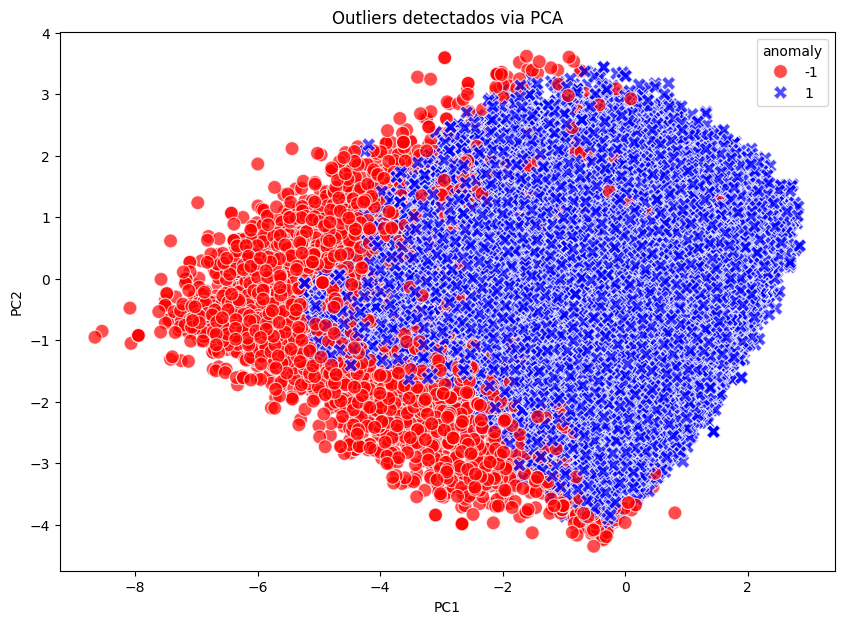

In [5]:
# --- Célula 9: Detecção de Outliers com Isolation Forest ---

# Seleção e padronização das features
features_for_outliers = ['danceability', 'energy', 'loudness', 'acousticness', 'valence', 'instrumentalness']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features_for_outliers])

#Aplicação do Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso.fit_predict(X_scaled)
outliers = df[df['anomaly'] == -1]
print(f"Detectados {len(outliers)} outliers.")
display(outliers[['track_genre'] + features_for_outliers])

# Visualização PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df.index)
df_pca['anomaly'] = df['anomaly']
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='anomaly', palette={1: 'blue', -1: 'red'}, style='anomaly', s=100, alpha=0.7)
plt.title("Outliers detectados via PCA")
plt.show()

#remoção
df_no_outliers = df[df['anomaly'] != -1].copy()

# Agrupar gêneros pouco frequentes
min_count = 100  # ajuste conforme o tamanho do seu dataset
top_genres = df_no_outliers['track_genre'].value_counts()[lambda x: x >= min_count].index
df_no_outliers['track_genre_grouped'] = df_no_outliers['track_genre'].where(df_no_outliers['track_genre'].isin(top_genres), 'outros')


In [6]:
# --- Célula 10: Pré-processamento dos Dados ---
df_processed = df_no_outliers.copy()
# Imputação pela mediana
df_processed[num_features] = df_processed[num_features].fillna(df_processed[num_features].median())
# Padronização e normalização em todo o dataset
scaler = StandardScaler()
scaler_norm = MinMaxScaler()
df_processed[num_features] = scaler.fit_transform(df_processed[num_features])
df_processed[num_features] = scaler_norm.fit_transform(df_processed[num_features])

display(df_processed.head())

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,anomaly,track_genre_grouped
0,0.73,0.044043,0.686294,0.460989,0.721409,0.148187,0.032329,0.000001,0.352006,0.718593,0.394946,0.8,acoustic,1,acoustic
1,0.55,0.028566,0.426396,0.165983,0.407873,0.079067,0.927711,0.000006,0.092607,0.268342,0.348101,0.8,acoustic,1,acoustic
2,0.57,0.040255,0.444670,0.358987,0.632092,0.057720,0.210843,0.000000,0.108756,0.120603,0.342903,0.8,acoustic,1,acoustic
3,0.71,0.038557,0.270051,0.059581,0.369612,0.037617,0.908635,0.000071,0.123896,0.143719,0.816424,0.6,acoustic,1,acoustic
4,0.82,0.037969,0.627411,0.442989,0.633676,0.054508,0.470884,0.000000,0.074338,0.167839,0.538842,0.8,acoustic,1,acoustic


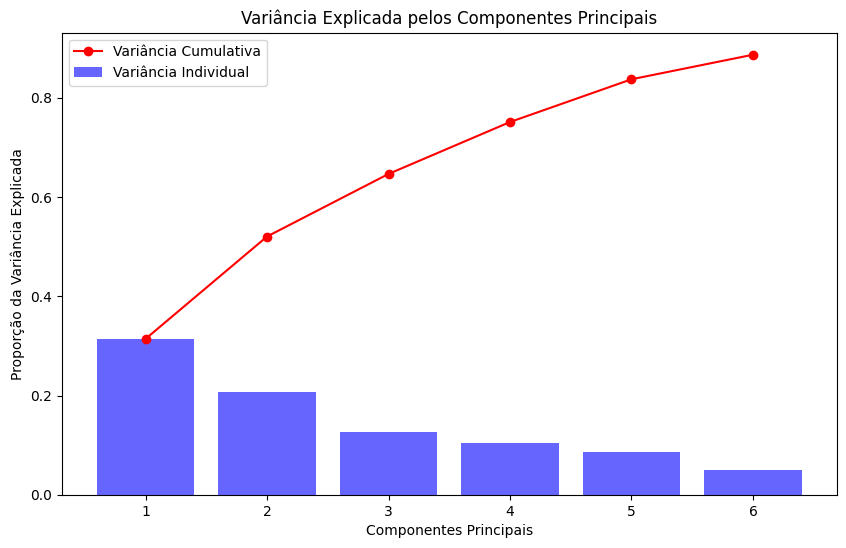

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,-0.145877,-0.231812,-0.159180,0.345582,0.115400,0.274919
1,0.893293,-0.041777,-0.253856,0.112065,-0.078753,0.026982
2,0.199220,0.162717,-0.430076,0.080609,-0.216757,0.180683
3,0.943398,0.070451,-0.475866,0.144619,-0.039586,-0.219247
4,0.323966,0.045746,-0.466837,0.332811,-0.100792,0.062746


In [21]:
# --- Célula 11: Redução de Dimensionalidade (PCA) (sem outliers) ---
n_components = 6
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(df_processed[num_features])
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.6, color='b', label='Variância Individual')
plt.plot(range(1, n_components + 1), cumulative_variance, 'r-o', label='Variância Cumulativa')
plt.xlabel('Componentes Principais')
plt.ylabel('Proporção da Variância Explicada')
plt.title('Variância Explicada pelos Componentes Principais')
plt.legend(loc='best')
plt.xticks(range(1, n_components + 1))
plt.show()

df_pca = pd.DataFrame(X_pca, columns=[f'PC_{i+1}' for i in range(n_components)], index=df_processed.index)
display(df_pca.head())


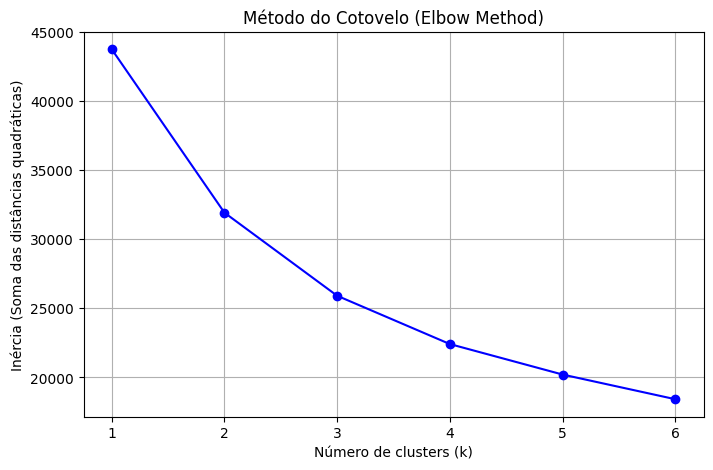

In [22]:
# --- Célula: Elbow Method para determinar o melhor número de clusters ---



# Use o DataFrame df_pca já criado após o PCA (sem a coluna 'cluster', se existir)
X_elbow = df_pca.drop(columns=['cluster'], errors='ignore')

inertias = []
k_range = range(1, 7)  # Testa de 1 a 6 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_elbow)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'o-', color='blue')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia (Soma das distâncias quadráticas)')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

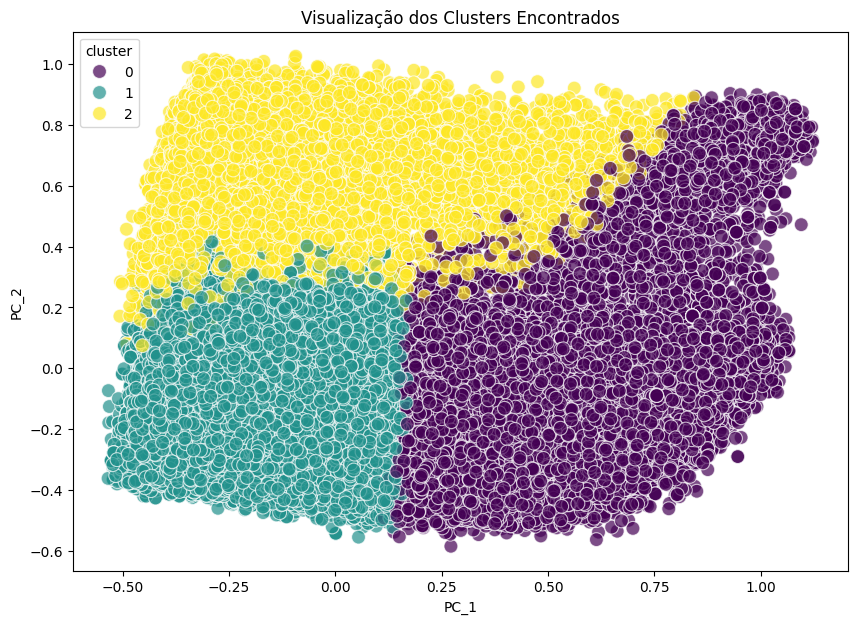

In [23]:
# --- Célula 12: Clusterização ---
k = 3
model = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = model.fit_predict(df_pca)
df_pca['cluster'] = labels

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC_1', y='PC_2', hue='cluster', palette='viridis', s=100, alpha=0.7)
plt.title("Visualização dos Clusters Encontrados")
plt.show()

Silhouette Score: 0.305
Davies-Bouldin Score: 1.256


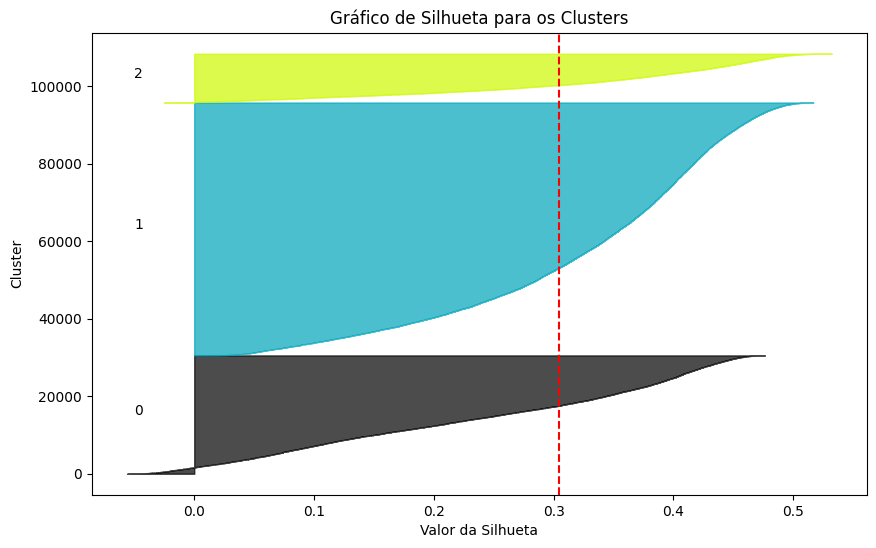

In [24]:
# --- Célula 13: Avaliação dos Clusters KMEANS ---
silhouette_avg = silhouette_score(df_pca.iloc[:, :-1], labels)
davies_bouldin = davies_bouldin_score(df_pca.iloc[:, :-1], labels)
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")

from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Calcula os valores de silhueta para cada ponto
silhouette_vals = silhouette_samples(df_pca.iloc[:, :-1], labels)

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(k):
    ith_cluster_silhouette_values = silhouette_vals[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / k)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper

plt.xlabel("Valor da Silhueta")
plt.ylabel("Cluster")
plt.title("Gráfico de Silhueta para os Clusters")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.show()

In [16]:
#Definir melhor eps(parametro) para dbscan
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=30)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances[:, 9])  # 9 porque n_neighbors=10
plt.plot(distances)
plt.ylabel('10th Nearest Neighbor Distance')
plt.xlabel('Points sorted by distance')
plt.show()

NameError: name 'X' is not defined

In [26]:
# --- Célula: Comparação Individual dos Algoritmos de Clusterização (com amostragem para os mais lentos) ---

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

resultados = []

X = df_pca.iloc[:, :-1]  # já definido anteriormente

# KMeans (rápido)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)
sil_kmeans = silhouette_score(X, kmeans_labels)
resultados.append({"Algoritmo": "KMeans", "Clusters": len(set(kmeans_labels)), "Silhouette": sil_kmeans})

# MeanShift (lento)
X_ms = X.sample(n=5000, random_state=42) if len(X) > 5000 else X
ms = MeanShift()
ms_labels = ms.fit_predict(X_ms)
n_clusters_ms = len(set(ms_labels))
sil_ms = silhouette_score(X_ms, ms_labels) if n_clusters_ms > 1 else np.nan
resultados.append({"Algoritmo": "MeanShift", "Clusters": n_clusters_ms, "Silhouette": sil_ms})

# DBSCAN (médio)
X_db = X.sample(n=3000, random_state=42) if len(X) > 3000 else X
dbscan = DBSCAN(eps=0.1, min_samples=30)
dbscan_labels = dbscan.fit_predict(X_db)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
if n_clusters_dbscan > 1:
    mask = dbscan_labels != -1
    sil_dbscan = silhouette_score(X_db[mask], dbscan_labels[mask])
else:
    sil_dbscan = np.nan
resultados.append({"Algoritmo": "DBSCAN", "Clusters": n_clusters_dbscan, "Silhouette": sil_dbscan})

# Agglomerative (médio)
X_agg = X.sample(n=3000, random_state=42) if len(X) > 3000 else X
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(X_agg)
sil_agg = silhouette_score(X_agg, agg_labels)
resultados.append({"Algoritmo": "Agglomerative", "Clusters": len(set(agg_labels)), "Silhouette": sil_agg})

# Spectral Clustering (lento)
X_sc = X.sample(n=1500, random_state=42) if len(X) > 1500 else X
sc = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
sc_labels = sc.fit_predict(X_sc)
sil_sc = silhouette_score(X_sc, sc_labels)
resultados.append({"Algoritmo": "Spectral", "Clusters": len(set(sc_labels)), "Silhouette": sil_sc})

# Gaussian Mixture Model (rápido)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X)
sil_gmm = silhouette_score(X, gmm_labels)
resultados.append({"Algoritmo": "GMM", "Clusters": len(set(gmm_labels)), "Silhouette": sil_gmm})

# Exibir resultados
resultados_df = pd.DataFrame(resultados)
display(resultados_df)

,Algoritmo,Clusters,Silhouette
0,KMeans,3,0.304501
1,MeanShift,2,0.297459
2,DBSCAN,0,NaN
3,Agglomerative,3,0.253993
4,Spectral,3,0.284944
5,GMM,3,0.150780


c:\Users\Gabriel Augusto\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


MemoryError: Unable to allocate 43.7 GiB for an array with shape (5864390850,) and data type float64

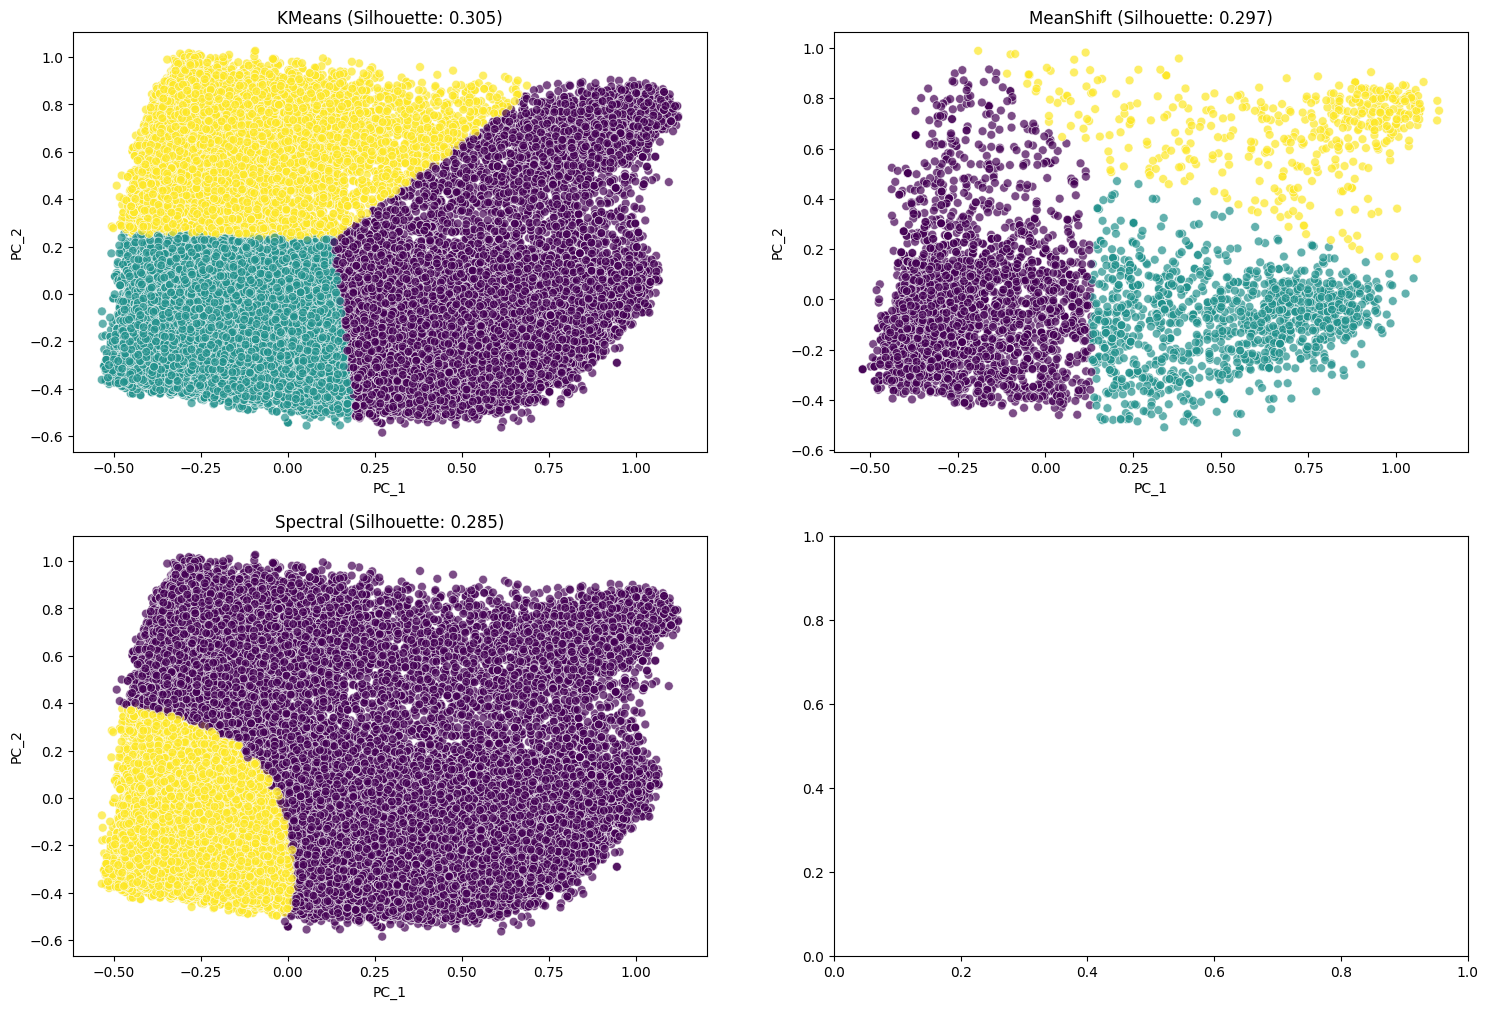

In [27]:
# --- Visualização dos clusters dos 4 melhores algoritmos de clusterização ---

# Ordena os resultados pelo Silhouette Score (quanto maior, melhor)
resultados_df_sorted = resultados_df.sort_values(by="Silhouette", ascending=False).reset_index(drop=True)
top4 = resultados_df_sorted.head(4)["Algoritmo"].tolist()

# Dicionário para instanciar novamente os modelos
algoritmos = {
    "KMeans": KMeans(n_clusters=3, random_state=42, n_init=10),
    "MeanShift": MeanShift(),
    "DBSCAN": DBSCAN(eps=0.1, min_samples=30),
    "Agglomerative": AgglomerativeClustering(n_clusters=3),
    "Spectral": SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42),
    "GMM": GaussianMixture(n_components=3, random_state=42)
}

# Usa sempre os dois primeiros componentes principais para visualização
X_vis = df_pca.iloc[:, :2].values

plt.figure(figsize=(18, 12))
for i, nome in enumerate(top4):
    plt.subplot(2, 2, i+1)
    modelo = algoritmos[nome]
    # Para DBSCAN e MeanShift, pode ser necessário amostrar para performance
    if nome == "MeanShift":
        X_plot = X_vis if len(X_vis) <= 5000 else X_vis[:5000]
        labels = modelo.fit_predict(X_plot)
    elif nome == "DBSCAN":
        X_plot = X_vis if len(X_vis) <= 3000 else X_vis[:3000]
        labels = modelo.fit_predict(X_plot)
    else:
        X_plot = X_vis
        labels = modelo.fit_predict(X_plot)
    sns.scatterplot(x=X_plot[:, 0], y=X_plot[:, 1], hue=labels, palette='viridis', s=40, alpha=0.7, legend=False)
    plt.title(f"{nome} (Silhouette: {resultados_df[resultados_df['Algoritmo']==nome]['Silhouette'].values[0]:.3f})")
    plt.xlabel("PC_1")
    plt.ylabel("PC_2")
plt.tight_layout()
plt.suptitle("Visualização dos 4 Melhores Algoritmos de Clusterização", fontsize=18, y=1.02)
plt.show()

df_shap.columns: ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']
num_features: ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
df_shap[num_features].shape: (114000, 12)
X_train.columns: ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
X_train.shape: (114000, 12)
model_rf.n_features_in_: 12
shap_values[0].shape: (12, 114)


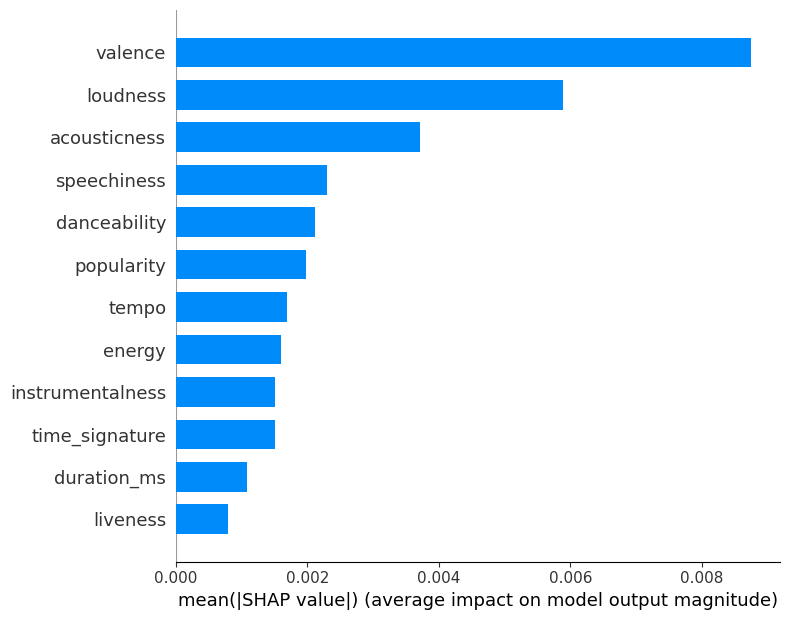

popularity          0.123311
duration_ms         0.095766
acousticness        0.094137
speechiness         0.092691
tempo               0.091402
danceability        0.089958
valence             0.087560
loudness            0.086596
energy              0.084649
liveness            0.076694
instrumentalness    0.068250
time_signature      0.008986
dtype: float64


In [23]:
# --- Célula 14: Interpretação SHAP ---
num_features = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]
df_shap = df[num_features + ['track_genre']].copy()

print("df_shap.columns:", list(df_shap.columns))
print("num_features:", num_features)
print("df_shap[num_features].shape:", df_shap[num_features].shape)

X_train = df_shap[num_features].copy()
y_train = df_shap['track_genre']

print("X_train.columns:", list(X_train.columns))
print("X_train.shape:", X_train.shape)

X_sample = X_train.sample(n=12, random_state=42) if len(X_train) > 12 else X_train

model_rf = RandomForestClassifier(n_estimators=30, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)

print("model_rf.n_features_in_:", model_rf.n_features_in_)

explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_sample)
print("shap_values[0].shape:", shap_values[0].shape)
shap.summary_plot(shap_values[0][:, :X_sample.shape[1]], X_sample, plot_type="bar")

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=30, random_state=42)
rf.fit(df_processed[num_features], df_no_outliers['track_genre'])
importances = pd.Series(rf.feature_importances_, index=num_features).sort_values(ascending=False)
print(importances)
# Use as top N features mais importantes
selected_features = importances.head(10).index.tolist()


In [24]:
# --- Célula: Classificação com mais modelos ---

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 1. Agrupar gêneros pouco frequentes (top N)
top_n = 10  # ajuste conforme desejar
top_genres = df_no_outliers['track_genre'].value_counts().nlargest(top_n).index
df_no_outliers['track_genre_grouped'] = df_no_outliers['track_genre'].where(df_no_outliers['track_genre'].isin(top_genres), 'outros')

# 2. Usar apenas as features mais importantes
X = df_processed[selected_features]
y = df_no_outliers['track_genre_grouped']

# 3. Remover a classe 'outros'
mask = y != 'outros'
X = X[mask]
y = y[mask]

# Codificar os rótulos para inteiros
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y_encoded)

# 5. Limitar o tamanho do dataset balanceado (opcional)
max_samples = 5000  # ajuste conforme sua memória
if X_bal.shape[0] > max_samples:
    X_bal, y_bal = resample(X_bal, y_bal, n_samples=max_samples, random_state=42, stratify=y_bal)

# 6. Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

# 7. Treinamento e avaliação
models = {
    "RandomForest": RandomForestClassifier(n_estimators=70, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBClassifier": XGBClassifier(n_estimators=70, use_label_encoder=False, eval_metric='mlogloss'),
    "LGBMClassifier": LGBMClassifier(n_estimators=70, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=70, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=70, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "KNeighbors": KNeighborsClassifier(n_neighbors=7),
    "SVC": SVC(kernel='rbf', probability=True, random_state=42),
    "NaiveBayes": GaussianNB()
}

for name, model in models.items():
    print("="*50)
    print(f"Modelo: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Acurácia teste: {accuracy_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred), digits=2))
    # Matriz de confusão como DataFrame
    conf_df = pd.DataFrame(
        confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred)),
        index=le.classes_, columns=le.classes_
    )
    print("\nMatriz de Confusão:")
    print(conf_df)
    # Cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='accuracy')
    print(f"\nCV Accuracy média: {np.mean(cv_scores):.3f} | Desvio: {np.std(cv_scores):.3f}")
    print("="*50)

Modelo: RandomForest
Acurácia teste: 0.791

Classification Report:
              precision    recall  f1-score   support

    cantopop       0.91      0.87      0.89       100
       dance       0.70      0.65      0.67       100
   dancehall       0.83      0.80      0.82       100
         edm       0.68      0.74      0.71       100
     electro       0.70      0.62      0.66       100
       forro       0.82      0.97      0.89       100
      gospel       0.82      0.88      0.85       100
       happy       0.81      0.83      0.82       100
   hard-rock       0.81      0.79      0.80       100
   hardstyle       0.83      0.76      0.79       100

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000


Matriz de Confusão:
           cantopop  dance  dancehall  edm  electro  forro  gospel  happy  \
cantopop         87      0          1    0        0      1       9      0   

In [27]:
# --- Geração de Tabela de Resultados para Relatório ---

def tabela_resultados(y_true, y_pred, le, modelo_nome, dataset_nome="Teste"):
    """
    Gera DataFrame no formato do relatório para um modelo e conjunto (treino ou teste).
    """
    report = classification_report(le.inverse_transform(y_true), le.inverse_transform(y_pred), output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    classes = le.classes_

    tabela = pd.DataFrame({
        "Métrica": ["Precisão", "Recall", "F1-Score", "Suporte", "Acurácia"],
    })

    for cls in classes:
        tabela[cls] = [
            f"{report[cls]['precision']:.3f}".replace('.', ','),
            f"{report[cls]['recall']:.3f}".replace('.', ','),
            f"{report[cls]['f1-score']:.3f}".replace('.', ','),
            int(report[cls]['support']),
            "-"  # Acurácia por classe não existe
        ]

    tabela["Média"] = [
        f"{report['macro avg']['precision']:.3f}".replace('.', ','),
        f"{report['macro avg']['recall']:.3f}".replace('.', ','),
        f"{report['macro avg']['f1-score']:.3f}".replace('.', ','),
        int(report['macro avg']['support']),
        f"{accuracy:.3f}".replace('.', ',')
    ]
    tabela["Média Ponderada"] = [
        f"{report['weighted avg']['precision']:.3f}".replace('.', ','),
        f"{report['weighted avg']['recall']:.3f}".replace('.', ','),
        f"{report['weighted avg']['f1-score']:.3f}".replace('.', ','),
        int(report['weighted avg']['support']),
        "-"
    ]
    tabela.insert(0, "Modelo", modelo_nome)
    tabela.insert(1, "Conjunto", dataset_nome)
    return tabela

# Exemplo de uso após o loop de modelos:
tabelas_treino = []
tabelas_teste = []

for name, model in models.items():
    # Treino
    y_pred_train = model.predict(X_train)
    tabela_train = tabela_resultados(y_train, y_pred_train, le, name, "Treino")
    tabelas_treino.append(tabela_train)
    # Teste
    y_pred_test = model.predict(X_test)
    tabela_test = tabela_resultados(y_test, y_pred_test, le, name, "Teste")
    tabelas_teste.append(tabela_test)

# Concatenar e exibir as tabelas finais
tabela_final_treino = pd.concat(tabelas_treino, ignore_index=True)
tabela_final_teste = pd.concat(tabelas_teste, ignore_index=True)

print("Tabela - Resultados no Treino")
display(tabela_final_treino)
print("Tabela - Resultados no Teste")
display(tabela_final_teste)

tabela_final_treino.to_excel("resultados_treino.xlsx", index=False)
tabela_final_teste.to_excel("resultados_teste.xlsx", index=False)

Tabela - Resultados no Treino


,Modelo,Conjunto,Métrica,cantopop,dance,dancehall,edm,electro,forro,gospel,happy,hard-rock,hardstyle,Média,Média Ponderada
0,RandomForest,Treino,Precisão,"1,000","0,892","0,983","0,873","0,936","1,000","1,000","0,988","1,000","0,990","0,966","0,966"
1,RandomForest,Treino,Recall,"1,000","0,910","0,985","0,873","0,915","1,000","1,000","0,990","1,000","0,988","0,966","0,966"
2,RandomForest,Treino,F1-Score,"1,000","0,901","0,984","0,873","0,925","1,000","1,000","0,989","1,000","0,989","0,966","0,966"
3,RandomForest,Treino,Suporte,400,400,400,400,400,400,400,400,400,400,4000,4000
4,RandomForest,Treino,Acurácia,-,-,-,-,-,-,-,-,-,-,"0,966",-
5,LogisticRegression,Treino,Precisão,"0,588","0,379","0,555","0,314","0,185","0,594","0,491","0,457","0,531","0,482","0,458","0,458"
6,LogisticRegression,Treino,Recall,"0,635","0,460","0,583","0,225","0,077","0,728","0,495","0,565","0,580","0,463","0,481","0,481"
7,LogisticRegression,Treino,F1-Score,"0,611","0,416","0,568","0,262","0,109","0,654","0,493","0,506","0,554","0,472","0,464","0,464"
8,LogisticRegression,Treino,Suporte,400,400,400,400,400,400,400,400,400,400,4000,4000
9,LogisticRegression,Treino,Acurácia,-,-,-,-,-,-,-,-,-,-,"0,481",-


Tabela - Resultados no Teste


,Modelo,Conjunto,Métrica,cantopop,dance,dancehall,edm,electro,forro,gospel,happy,hard-rock,hardstyle,Média,Média Ponderada
0,RandomForest,Teste,Precisão,"0,906","0,699","0,833","0,679","0,697","0,822","0,822","0,814","0,806","0,826","0,790","0,790"
1,RandomForest,Teste,Recall,"0,870","0,650","0,800","0,740","0,620","0,970","0,880","0,830","0,790","0,760","0,791","0,791"
2,RandomForest,Teste,F1-Score,"0,888","0,674","0,816","0,708","0,656","0,890","0,850","0,822","0,798","0,792","0,789","0,789"
3,RandomForest,Teste,Suporte,100,100,100,100,100,100,100,100,100,100,1000,1000
4,RandomForest,Teste,Acurácia,-,-,-,-,-,-,-,-,-,-,"0,791",-
5,LogisticRegression,Teste,Precisão,"0,598","0,468","0,574","0,370","0,333","0,595","0,532","0,488","0,513","0,521","0,499","0,499"
6,LogisticRegression,Teste,Recall,"0,640","0,520","0,620","0,270","0,140","0,780","0,590","0,620","0,600","0,380","0,516","0,516"
7,LogisticRegression,Teste,F1-Score,"0,618","0,493","0,596","0,312","0,197","0,675","0,559","0,546","0,553","0,439","0,499","0,499"
8,LogisticRegression,Teste,Suporte,100,100,100,100,100,100,100,100,100,100,1000,1000
9,LogisticRegression,Teste,Acurácia,-,-,-,-,-,-,-,-,-,-,"0,516",-


In [23]:
# --- Célula: Classificação focada nos gêneros mais comuns e features mais importantes ---

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 1. Agrupar gêneros pouco frequentes (top N)
top_n = 10  # ajuste conforme desejar
top_genres = df_no_outliers['track_genre'].value_counts().nlargest(top_n).index
df_no_outliers['track_genre_grouped'] = df_no_outliers['track_genre'].where(df_no_outliers['track_genre'].isin(top_genres), 'outros')

# 2. Usar apenas as features mais importantes
X = df_processed[selected_features]
y = df_no_outliers['track_genre_grouped']

# 3. Remover a classe 'outros'
mask = y != 'outros'
X = X[mask]
y = y[mask]

# Codificar os rótulos para inteiros
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y_encoded)

# 5. Limitar o tamanho do dataset balanceado (opcional)
#max_samples = 5000  # ajuste conforme sua memória
if X_bal.shape[0] > max_samples:
    X_bal, y_bal = resample(X_bal, y_bal, n_samples=max_samples, random_state=42, stratify=y_bal)

# 6. Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)
# 7. Treinamento e avaliação
models = {
    "RandomForest": RandomForestClassifier(n_estimators=70, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBClassifier": XGBClassifier(n_estimators=70, use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    print("="*50)
    print(f"Modelo: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Acurácia teste: {accuracy_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred), digits=2))
    # Matriz de confusão como DataFrame
    conf_df = pd.DataFrame(
        confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred)),
        index=le.classes_, columns=le.classes_
    )
    print("\nMatriz de Confusão:")
    print(conf_df)
    # Cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='accuracy')
    print(f"\nCV Accuracy média: {np.mean(cv_scores):.3f} | Desvio: {np.std(cv_scores):.3f}")
    print("="*50)

Modelo: RandomForest
Acurácia teste: 0.791

Classification Report:
              precision    recall  f1-score   support

    cantopop       0.91      0.87      0.89       100
       dance       0.70      0.65      0.67       100
   dancehall       0.83      0.80      0.82       100
         edm       0.68      0.74      0.71       100
     electro       0.70      0.62      0.66       100
       forro       0.82      0.97      0.89       100
      gospel       0.82      0.88      0.85       100
       happy       0.81      0.83      0.82       100
   hard-rock       0.81      0.79      0.80       100
   hardstyle       0.83      0.76      0.79       100

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000


Matriz de Confusão:
           cantopop  dance  dancehall  edm  electro  forro  gospel  happy  \
cantopop         87      0          1    0        0      1       9      0   